In [1]:
import numpy as np
import os
import pandas as pd
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.model_selection import GridSearchCV

In [3]:
def get_clf_eval(y_test,pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred, average = 'macro')
    recall = recall_score(y_test,pred, average = 'macro')
    f1 = f1_score(y_test, pred, average = 'macro')
    roc_auc = roc_auc_score(y_test, pred_proba, average = 'macro', multi_class='ovr')
    print('Confusion matrix')
    print(confusion)
    print('Accuracy:{0:.4f}, Precision:{1:.4f}, Recall:{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 1. Load train and test data

In [4]:
train_data = pd.read_csv("data/train_data_PCA.csv", header=None)
test_data = pd.read_csv("data/test_data_PCA.csv", header=None)

X_train = train_data.iloc[:,:2]
y_train = train_data.iloc[:,2]

X_test = test_data.iloc[:,:2]
y_test = test_data.iloc[:,2]

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

### 2. Train the LightGBM model

In [5]:
lgbm_clf = LGBMClassifier(objective = 'multi:softmax', num_class='4')

params = {'max_depth': [10, 110, 10],
          'num_leaves': [32, 64],
          'min_child_samples': [60,100],
          'min_child_weight' : [1,3],
          'colsample_bytree' : [0.5,0.75],
          'n_estimators' : range(40, 440, 40)}

In [6]:
grid_search = GridSearchCV(estimator = lgbm_clf, param_grid=params, scoring = 'accuracy', n_jobs=-1, cv = 5, verbose=True)

In [7]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(num_class='4', objective='multi:softmax'),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.75],
                         'max_depth': [10, 110, 10],
                         'min_child_samples': [60, 100],
                         'min_child_weight': [1, 3],
                         'n_estimators': range(40, 440, 40),
                         'num_leaves': [32, 64]},
             scoring='accuracy', verbose=True)

In [8]:
scores_df = pd.DataFrame(grid_search.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 
           'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,"{'colsample_bytree': 0.5, 'max_depth': 10, 'mi...",0.632778,259,0.643056,0.643056,0.613889,0.632639,0.631250
1,"{'colsample_bytree': 0.5, 'max_depth': 10, 'mi...",0.633333,255,0.640278,0.645139,0.613194,0.632639,0.635417
2,"{'colsample_bytree': 0.5, 'max_depth': 10, 'mi...",0.629583,272,0.632639,0.636806,0.613889,0.627778,0.636806
3,"{'colsample_bytree': 0.5, 'max_depth': 10, 'mi...",0.628889,281,0.630556,0.637500,0.614583,0.626389,0.635417
4,"{'colsample_bytree': 0.5, 'max_depth': 10, 'mi...",0.624444,306,0.619444,0.633333,0.616667,0.622917,0.629861
...,...,...,...,...,...,...,...,...
475,"{'colsample_bytree': 0.75, 'max_depth': 10, 'm...",0.903333,125,0.894444,0.900694,0.895139,0.909722,0.916667
476,"{'colsample_bytree': 0.75, 'max_depth': 10, 'm...",0.900833,168,0.895139,0.900000,0.893056,0.906250,0.909722
477,"{'colsample_bytree': 0.75, 'max_depth': 10, 'm...",0.902500,138,0.895139,0.899306,0.893750,0.907639,0.916667
478,"{'colsample_bytree': 0.75, 'max_depth': 10, 'm...",0.900278,176,0.895139,0.898611,0.892361,0.905556,0.909722


In [9]:
print("GridSearchCV optimal paramters:", grid_search.best_params_)
print("GridSearchCV the highest accuracy:{0:.4f}".format(grid_search.best_score_))

GridSearchCV optimal paramters: {'colsample_bytree': 0.75, 'max_depth': 10, 'min_child_samples': 100, 'min_child_weight': 1, 'n_estimators': 40, 'num_leaves': 64}
GridSearchCV the highest accuracy:0.9140


### 3. Test the LightGBM model

In [10]:
estimator = grid_search.best_estimator_

preds = estimator.predict(X_test_scaled)
pred_probs = estimator.predict_proba(X_test_scaled)

In [11]:
get_clf_eval(y_test, preds, pred_probs)

Confusion matrix
[[114   0  28  10]
 [  0 122  13   0]
 [  2   5 112   1]
 [  0   0   0 126]]
Accuracy:0.8893, Precision:0.8988, Recall:0.8968, F1:0.8902, AUC:0.9828


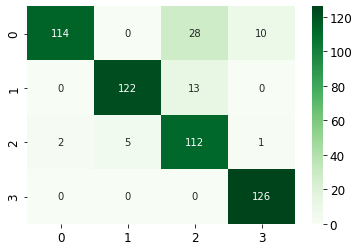

In [12]:
import seaborn as sns
cf_matrix = confusion_matrix(y_test,preds)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = np.asarray(group_counts).reshape(4,4)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')

In [13]:
print(metrics.classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9828    0.7500    0.8507       152
           1     0.9606    0.9037    0.9313       135
           2     0.7320    0.9333    0.8205       120
           3     0.9197    1.0000    0.9582       126

    accuracy                         0.8893       533
   macro avg     0.8988    0.8968    0.8902       533
weighted avg     0.9058    0.8893    0.8897       533



Text(0, 0.5, 'PC2')

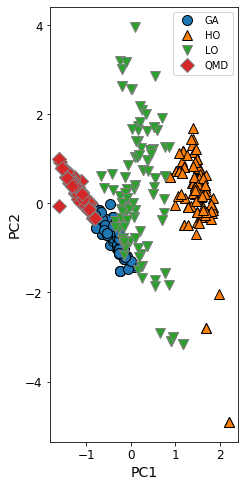

In [15]:
import mglearn

plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_test_scaled[:,0], X_test_scaled[:,1], preds)
plt.legend(["GA", "HO", "LO", "QMD"], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("PC1")
plt.ylabel("PC2")